# What is the propensity score?

In the laboratory, we investigate causal effects of interventions by carefully controlling all other variables. We take two genetically identical cultures of bacteria, grow them in the same medium at the same temperature, but treat one culture with an antibacterial agent. If the culture treated with the antibacterial dies while the other survives, we conclude the antibacterial agent somehow "causes" the bacteria to die.

In medicine, we want to understand if our treatment is helping the patient. This is again a causal question. Ideally, we would do exactly as we do in the laboratory. Take two identical populations of patients and give only one group the treatment and wait to see which population fairs better. It's very difficult to find two groups of patients that are _exactly_ identical. However, we can remove systematic differences between two groups by randomizing the treatment assignment. This is exactly the idea of the randomized clinical trial (RCT).

In randomizing the treatment assignment, we ensure that the only systematic difference between the two groups is the treatment and therefore any observed differences in outcome is likely due to the treatment. An RCT is not always possible, however. For example, it would be unethical to perform an RCT to investigate the effects of smoking on the risk of lung cancer. In such cases, we need to draw causal conclusions from data that already exist, rather than generating the data ourselves. The main problem is that we have to take into account that the treatment is not randomly assigned. This is where the propensity score enters. The propensity score tells us, under some general conditions, how to take a non-randomized treatment assignment and make it _look_ like a randomized one.

There are a lot of great resources on the topic of propensity score and I will not go into theory here that is well-documented elsewhere (see references below). Instead, I want to give an illustration of the theory in action in a toy example. Part of my motivation is that there seems to be a lot of misunderstanding of what a propensity is, what is does, how to estimate it, how to use it, etc. I'm a visual learner and I think it helps to explain away these misunderstandings with pictures. So here we go.


# Basic Properties of the Propensity Score

Propensity score (PS) is defined as the probability of receiving treatment:

$$ e(\vec{x}) := P(z=1|\vec{x}),$$

where $\vec{x}$ is a vector of patient characteristics and $z\in \{0, 1\}$ denotes the possible treatments.

The first important property of the propensity score is that, conditional on the propensity score, the distribution of patient characteristics is independent of the treatment. That is,

$$ P(\vec{x}| z=1, e) = P(\vec{x}|z=0, e). $$

I still think this is a really cool result, so let's take a minute to appreciate it with an example.

In [127]:
import seaborn as sns
import style
import numpy as np
import pandas as pd
#random.multivariate_normal(mean, cov
                           
def generate_patient_data(N=1000):

    # See: https://www.nature.com/articles/s41598-021-89442-7

    min_age = 18
    max_age = 85
    age = np.random.uniform(min_age, max_age, size=N)

    # EGFR decreases with age
    egfr_center = 110 - np.clip(age - 30, 0, 85) # at age = 85 --> egfr = 55
    egfr_low = egfr_center - 40                  # at age = 85 --> egfr = 15
    egfr_high = egfr_center + 40                 # at age = 85 --> egfr = 95
    
    # Exponents are to produce a negatively skewed distribution
    egfr = np.random.uniform(egfr_low**2, egfr_high**2, size=N)**(1./2)
    
    return np.vstack((age, egfr)).T

In [157]:
from scipy.stats import cauchy
def treament_assignment(row):

    age, egfr = row
    
    # treat_range_egfr = 25 - 75
    p_treat_egfr = cauchy.pdf( (egfr - 50)/30 ) / cauchy.pdf(0)

    # treat_range_age = 30 - 70
    p_treat_age = cauchy.pdf( (age - 50)/20 ) / cauchy.pdf(0)
    
    return p_treat_age * p_treat_egfr
    

In [158]:
x = generate_patient_data(10000)
df = pd.DataFrame.from_records(x, columns=['age', 'eGFR'])
p_treat = df.apply(treament_assignment, axis=1)
print(p_treat.min(), p_treat.max(), p_treat.mean())
df.loc[:, 'p_treat'] = p_treat
df.loc[:, 'treat'] = (np.random.rand(N) < df['p_treat']).astype(int)

0.01698322591566782 0.9994117614689731 0.2131922709479698


<AxesSubplot:xlabel='eGFR', ylabel='Probability'>

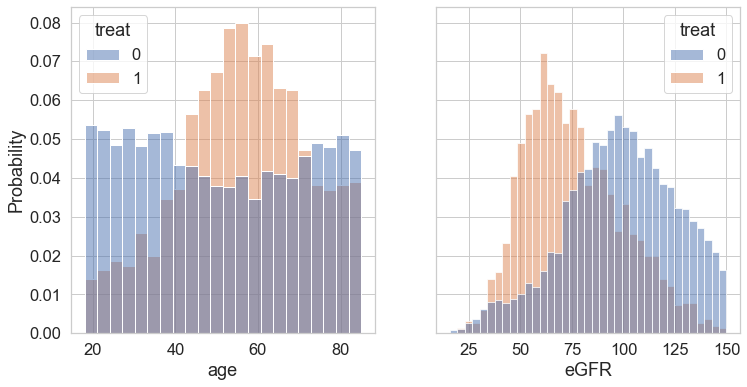

In [169]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12,6))
sns.histplot(data=df, x='age', hue='treat', common_norm=False, stat='probability', ax=axes[0])
sns.histplot(data=df, x='eGFR', hue='treat', common_norm=False, stat='probability', ax=axes[1])

<AxesSubplot:xlabel='eGFR', ylabel='Probability'>

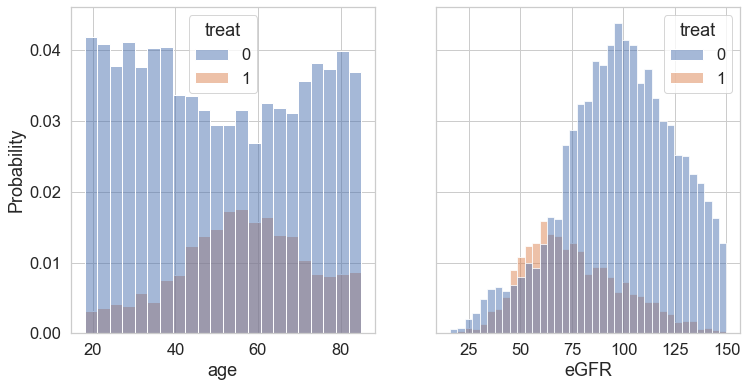

In [170]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12,6))
sns.histplot(data=df, x='age', hue='treat', stat='probability', ax=axes[0])
sns.histplot(data=df, x='eGFR', hue='treat', stat='probability', ax=axes[1])

<AxesSubplot:xlabel='age', ylabel='eGFR'>

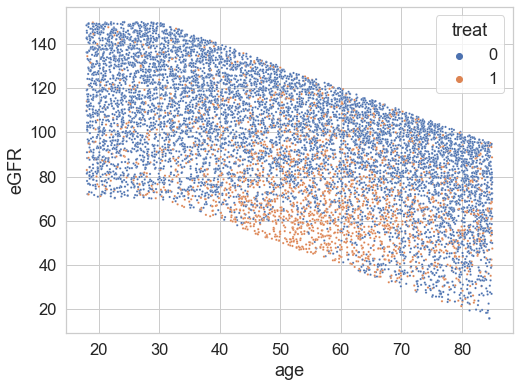

In [160]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='age', y='eGFR', s=5, hue='treat')

<AxesSubplot:xlabel='eGFR', ylabel='Count'>

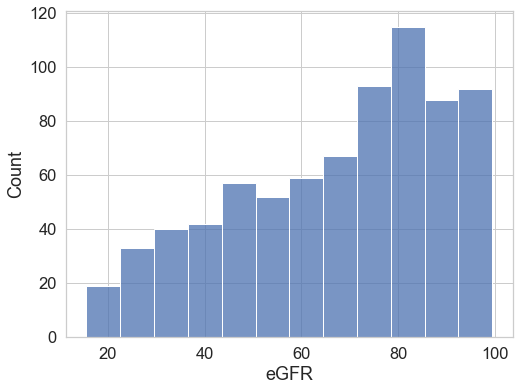

In [129]:
sns.histplot(data=df[df['age'] > 80], x='eGFR')

Under the assumptions that 

(1) $\vec{x}$ fully describes all information relevant for treatment assignment and outcome

(2) $0 < e(\vec{x}) < 1$ for all values of $\vec{x}$ in your populations,

theory tells us that 

$$ \int_0^1 E[r_1 | z=1, e(\vec{x})] - E[r_0 | z=0, e(\vec{x})] de, $$

where $r_z$ denotes the outcome under treatment $z$, is an unbiased estimate of the average treatment effect.

We want to explore the effect of model misspecification on the propensity score. To do so, we'll consider a few toy problems:

1) incorrectly specified propensity model
2) fix (1) to correctly specify model
3) CBPS
4) unmeasured confounding and CBPS

In [90]:
# CHADSVASc
# Congestive heart failure 
# Hypertension
# Age ≥75 years (2)
# Diabetes Mellitus
# Prior Stroke or TIA or thromboembolism (2)
# Vascular disease (e.g. peripheral artery disease, myocardial infarction, aortic plaque)	1
# Age 65–74 years
# Sex category (i.e. female sex)

# HASBLED
# Hypertension 
# Renal disease
# Liver disease
# Stroke 
# Prior bleed
# Labile INR
# Age > 65
# Aspirin
# Alcohol use
import numpy as np
import pandas as pd

def true_propensity_model(covariates):    
    age, n_comedications = covariates
    score = age * n_comedications / (80)
    return 1 / (1 + np.exp(score - 1))

def true_outcome_model(covariates):
    age, n_comedications, treat = covariates
    if treat:
        risk = 0.1

In [91]:
N = 10000
min_age = 18
max_age = 90
age = min_age + (max_age - min_age) * np.random.rand(N)
age.min(), age.max()
n_comedications = np.random.poisson(lam=age / 65)
baseline_data = pd.DataFrame.from_dict({
    'age':age,
    'n_comedications':n_comedications
})
baseline_data.loc[:, 'ps_true'] = baseline_data.apply(true_propensity_model, axis=1)
baseline_data.loc[:, 'treat'] = (np.random.rand(N) < baseline_data['ps_true']).astype(int)
baseline_data

,age,n_comedications,ps_true,treat
0,62.976131,1,0.553000,0
1,62.111242,1,0.555671,1
2,45.523001,1,0.606103,1
3,39.574634,1,0.623708,0
4,44.831112,0,0.731059,1
...,...,...,...,...
9995,86.198349,3,0.096875,0
9996,30.984698,0,0.731059,1
9997,28.302063,0,0.731059,1
9998,39.166675,0,0.731059,1


<AxesSubplot:xlabel='n_comedications', ylabel='Count'>

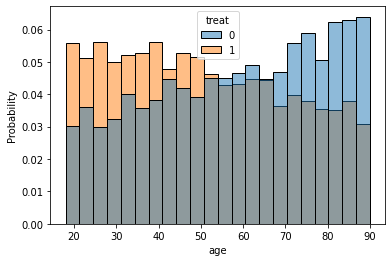

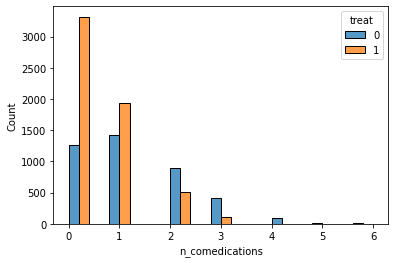

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.histplot(data=baseline_data, x='age', hue='treat', stat='probability', common_norm=False,)
plt.figure()
sns.histplot(data=baseline_data, x='n_comedications', multiple='dodge', binwidth=0.4, hue='treat')

In [93]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

pp = StandardScaler()
X_train = pp.fit_transform(baseline_data[['age', 'n_comedications']])

clf = LogisticRegression()
clf.fit(X_train, baseline_data['treat'])

baseline_data.loc[:, 'ps_pred'] = clf.predict_proba(X_train)[:, 1]

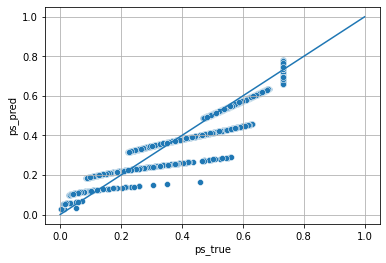

In [94]:
sns.scatterplot(data=baseline_data, x='ps_true', y='ps_pred')
plt.plot([0, 1], [0, 1])
plt.grid()

In [95]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

pp = StandardScaler()
baseline_data.loc[:, 'age*n_comedications'] = baseline_data['age'] * baseline_data['n_comedications']
X_train = pp.fit_transform(baseline_data[['age', 'n_comedications', 'age*n_comedications']])

clf = LogisticRegression()
clf.fit(X_train, baseline_data['treat'])

baseline_data.loc[:, 'ps_pred'] = clf.predict_proba(X_train)[:, 1]

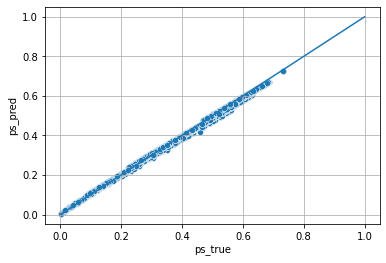

In [96]:
sns.scatterplot(data=baseline_data, x='ps_true', y='ps_pred')
plt.plot([0, 1], [0, 1])
plt.grid()

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

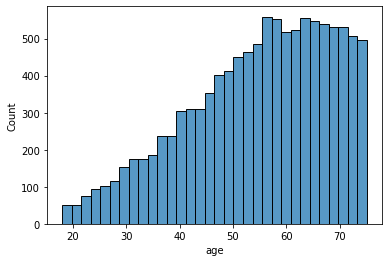

In [21]:
#| label: fig-plot
#| fig-cap: "A snapshot of the data"

df = pd.read_parquet('/Users/sprivite/data/x-corDat-stephen-F/pool10000-target1000-normal0-lognormal0-binary0.parquet')
sns.histplot(data=df, x='age')
plt.show()

# Further Learning

Here are some resources for learning more about this topic:

1. _The Central Role of the Propensity Score in Observational Studies for Causal Effects_, Rosenbaum and Rubin, 1983. 

This is the classic paper on propensity score. A must read.

2. _An Introduction to Propensity Score Methods for Reducing the Effects of Confounding in Observational Studies_, Austin, 2011.

A great general introduction to propensity score and its applications.

3. _Modern Algorithms for Matching in Observational Studies_, Rosenbaum, 2020.

This is a good modern review of matching methods in general.

